In [1]:
%matplotlib inline

from core import *

samples = analysis_set["main"]

def get_kmer_profiles(rna, subsample = 100000, min_l = 2, max_l = 7):
    infile = samfiles[rna]
    print("Processing sample", infile)
    seqs = read_samfile(rna, infile, subsample)
    
    kmer_dict = {kmer:[0, 0, []] for kmer in init_homodict(min_l, max_l)}
    
    for seq_num in tqdm(range(np.minimum(len(seqs), subsample))):
        name, flag, start, cigar, sample_seq, mapq, chromo, qs_base = seqs[seq_num]
        cigar_splitted = re.split('([^0-9])',cigar.strip())
        cigar_expanded, n_clips = '', 0
        for index in range(0, len(cigar_splitted)-1, 2): # items[-1] is actually ""
            count, symbol = int(cigar_splitted[index]), cigar_splitted[index+1]
            if symbol == "S":
                n_clips += count
            else:
                cigar_expanded = cigar_expanded + ''.join([symbol * count])
        ref_start = int(start) - 1 # samfiles are 1-based
        ref_end = ref_start + len(sample_seq) - cigar_expanded.count("I") + cigar_expanded.count("D") + cigar_expanded.count("N") - n_clips
        
        sample_seq = sample_seq[int(cigar_splitted[0]):] if cigar_splitted[1] == "S" else sample_seq
        sample_seq = sample_seq[:-int(cigar_splitted[-3])] if cigar_splitted[-2] == "S" else sample_seq
        ref_seq = refs[rna].fetch(reference = chromo, start = ref_start, end = ref_end)
        
        if "N" in ref_seq or ref_seq.upper() != ref_seq:
            continue
            
        strand = '-' if int(flag) & 0x10 else '+'
        if strand == '-':
            sample_seq = rev_compl(sample_seq)
            ref_seq = rev_compl(ref_seq)
            cigar_expanded = cigar_expanded[::-1]
        
        # Expand sample sequence by adding deletions _ and removing insertions
        expanded_sample, p_sample, p_ref, insert_pos = '', 0, 0, {}
        p_cigar = 0 if cigar_splitted[1] != "S" else 2
        
        for i in range(len(cigar_expanded)):
            if cigar_expanded[i] == "=" or cigar_expanded[i] == "X":
                expanded_sample += sample_seq[p_sample]
                p_sample += 1
                p_ref += 1
            elif cigar_expanded[i] == "D":
                expanded_sample += "_"
                p_ref += 1
            elif cigar_expanded[i] == "N":
                expanded_sample += "N"
                p_ref += 1
            elif cigar_expanded[i] == "I":
                if cigar_expanded[i-1] != "I":
                    insert_pos[p_ref] = sample_seq[p_sample] if sample_seq[p_sample] != "T" else "U" 
                    p_sample += 1
                    step = 1
                    while cigar_expanded[i+step] == "I":
                        insert_pos[p_ref] += sample_seq[p_sample] if sample_seq[p_sample] != "T" else "U"
                        step += 1
                        p_sample += 1                        
        
        if len(expanded_sample) != len(ref_seq):
            print("expansion didn't work!!")
        
        ref_seq = ref_seq.replace("T", "U")
        expanded_sample = expanded_sample.replace("T", "U")
        
        for kmer, homo_start, l in get_homo_pos(ref_seq, max_l):
            if "N" not in kmer:
                sample_kmer = expanded_sample[homo_start:homo_start + l]
                ins_flag, base2insert = False, []
                for j in range(homo_start, homo_start+l):
                    if j in insert_pos:
                        ins_flag = True
                        base2insert.append((j-i, insert_pos[j]))
                if ins_flag == True:
                    for loc, insert in base2insert:
                        inserted_kmer = sample_kmer[:loc] + insert + sample_kmer[loc:]
                    sample_kmer = inserted_kmer
                    # print(i, kmer, sample_kmer, inserted_kmer, base2insert)

                kmer_dict[kmer][1] += 1
                if sample_kmer == kmer:
                    kmer_dict[kmer][0] += 1
                sample_kmer = is_homop(sample_kmer, kmer[0]) 
                if sample_kmer != False:
                    kmer_dict[kmer][2].append(len(sample_kmer))
    return kmer_dict

kmer_profiles = {}
for sample in samples:
    kmer_profiles[sample] = get_kmer_profiles(sample)

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Processing sample eligos/HS_H460/h460_guppy.sam
The number of sequences in this sample with N is  87467
The number of supplementary alignments in this sample is  1228
The number of sequences in this sample is  100000


100%|██████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:27<00:00, 3629.25it/s]


Processing sample eligos/human_ivt/human_ivt_guppy.sam
The number of sequences in this sample with N is  62056
The number of supplementary alignments in this sample is  4487
The number of sequences in this sample is  100000


100%|██████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:12<00:00, 8271.95it/s]


Processing sample mouse/mouse_guppy.sam
The number of sequences in this sample with N is  105298
The number of supplementary alignments in this sample is  828
The number of sequences in this sample is  100000


100%|██████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:14<00:00, 6954.19it/s]


Processing sample epinano/epinano_yeast_rep2/yeast_guppy.sam
The number of sequences in this sample with N is  2879
The number of supplementary alignments in this sample is  225
The number of sequences in this sample is  100000


100%|██████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:39<00:00, 2519.75it/s]


Processing sample celegans/celegans_guppy.sam
The number of sequences in this sample with N is  93048
The number of supplementary alignments in this sample is  114
The number of sequences in this sample is  100000


100%|██████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:11<00:00, 8716.22it/s]


Processing sample regensburg/ecoli/ecoli_guppy.sam
The number of sequences in this sample with N is  39423
The number of supplementary alignments in this sample is  1429
The number of sequences in this sample is  100000


100%|███████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:37<00:00, 459.79it/s]


Processing sample sars2/sars2_guppy.sam
The number of sequences in this sample with N is  41497
The number of supplementary alignments in this sample is  225
The number of sequences in this sample is  100000


100%|███████████████████████████████████████████████████████████████████████████████| 100000/100000 [12:12<00:00, 136.44it/s]


Processing sample sars2/sars2ivt/sars2ivt_guppy.sam
The number of sequences in this sample with N is  8265
The number of supplementary alignments in this sample is  1712
The number of sequences in this sample is  100000


100%|███████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:46<00:00, 935.66it/s]


Processing sample parkersimpson2020/arabidopsis_guppy.sam
The number of sequences in this sample with N is  76942
The number of supplementary alignments in this sample is  715
The number of sequences in this sample is  100000


100%|██████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:10<00:00, 9214.48it/s]


Processing sample nanorms/small_rna_guppy.sam
The number of sequences in this sample with N is  12
The number of supplementary alignments in this sample is  178
The number of sequences in this sample is  31973


100%|████████████████████████████████████████████████████████████████████████████████| 31973/31973 [00:04<00:00, 7065.50it/s]


Processing sample nano3pseq/zebrafish_guppy.sam
The number of sequences in this sample with N is  86239
The number of supplementary alignments in this sample is  773
The number of sequences in this sample is  100000


100%|██████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:22<00:00, 4479.80it/s]


Processing sample regensburg/pfu/pfu_guppy.sam
The number of sequences in this sample with N is  1225
The number of supplementary alignments in this sample is  1146
The number of sequences in this sample is  100000


100%|██████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:43<00:00, 2275.20it/s]


In [11]:
for sample in samples:
    if len(kmer_profiles[sample]["UUUUUUU"][2]) > 0:
        print(sample, np.max(kmer_profiles[sample]["UUUUUUU"][2]))

Human 10
Human_IVT 8
Mouse 7
Yeast 28
C. elegans 21
E. coli 10
SARS2_IVT 7
Arabidopsis 9
shortRNAs_IVT 21
Zebrafish 9
P. furiosus 7


In [12]:
for sample in samples:
    kmer = "UUUUU"
    print(sample, kmer_profiles[sample][kmer][0], kmer_profiles[sample][kmer][1])

Human 2465 8101
Human_IVT 532 1586
Mouse 377 1621
Yeast 24791 106154
C. elegans 6740 16786
E. coli 3807 337723
SARS2 120085 2229678
SARS2_IVT 75288 277587
Arabidopsis 191 595
shortRNAs_IVT 3768 4132
Zebrafish 1457 14595
P. furiosus 255 13881


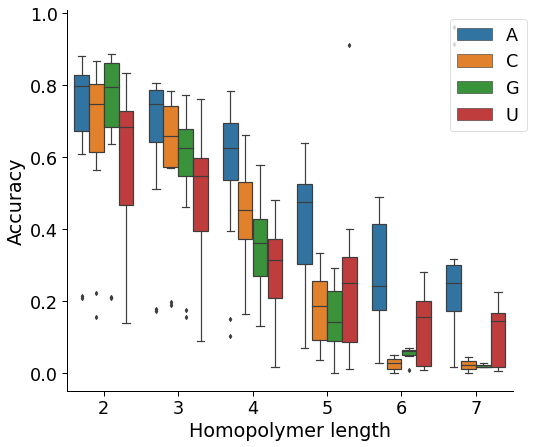

In [25]:
x, y, hue = [], [], []

for sample in samples:
    for kmer in sorted(kmer_profiles[sample].keys()):
        ref_count = kmer_profiles[sample][kmer][1]
        if ref_count > 100: 
            x.append(str(len(kmer)))
            hue.append(kmer[0])
            y.append(kmer_profiles[sample][kmer][0] / kmer_profiles[sample][kmer][1])

plt.figure(figsize = (8, 7))
sns.set_context("paper", font_scale = 2)
sns.boxplot(x = x, y = y, hue = hue, fliersize = 3, order = ["2", "3", "4", "5", "6", "7"])
sns.despine()
plt.xlabel("Homopolymer length"), plt.ylabel("Accuracy")
plt.legend(loc = 'upper right', bbox_to_anchor = (1.05, 1), fancybox = True, ncol = 1)
plt.savefig("images/homopolymer/homopolymer_acc", bbox_inches = "tight")
plt.show()

In [26]:
length = 0
for sample in samples:# ["Human", "Human_IVT"]:
    for ref_kmer in kmer_profiles[sample]:
        n = len(kmer_profiles[sample][ref_kmer][2])
        length += n
    print(sample, length)
    
# np.int8 is not good...
x, y = np.empty(length, dtype = np.int64), np.empty(length, dtype = np.int64)
hue = np.empty(length, dtype = "<U32")

l = 0
for sample in samples: #["Human", "Human_IVT"]:
    print(sample, l)
    for ref_kmer in kmer_profiles[sample]:
        n = len(kmer_profiles[sample][ref_kmer][2])
        x[l:l+n] = len(ref_kmer)
        hue[l:l+n] = ref_kmer[0]
        y[l:l+n] = kmer_profiles[sample][ref_kmer][2]
        l = l+n

Human 2428643
Human_IVT 2955631
Mouse 3454329
Yeast 12775102
C. elegans 13281185
E. coli 28140689
SARS2 82314975
SARS2_IVT 110471652
Arabidopsis 110645789
shortRNAs_IVT 111943830
Zebrafish 114008534
P. furiosus 123251889
Human 0
Human_IVT 2428643
Mouse 2955631
Yeast 3454329
C. elegans 12775102
E. coli 13281185
SARS2 28140689
SARS2_IVT 82314975
Arabidopsis 110471652
shortRNAs_IVT 110645789
Zebrafish 111943830
P. furiosus 114008534


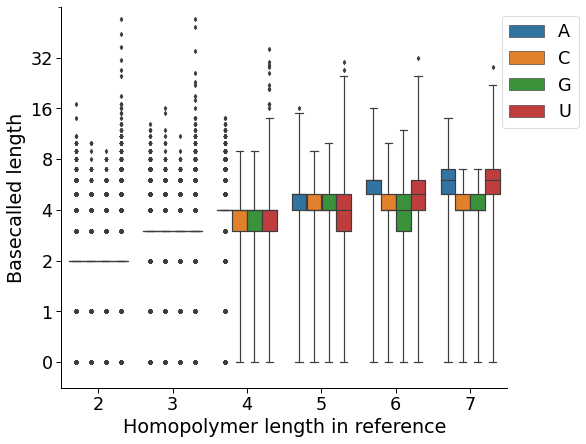

In [28]:
from matplotlib.ticker import ScalarFormatter
fig, ax = plt.subplots(figsize = (8, 7))
sns.set_context("paper", font_scale = 2)
sns.boxplot(x = x, y = y, hue = hue, whis=10, fliersize = 3, order = [2, 3, 4, 5, 6, 7], hue_order=["A", "C","G","U"])
sns.despine()
plt.legend(loc = 'upper right', bbox_to_anchor = (1.18, 1), fancybox = True, ncol = 1)
# plt.legend(loc = 'upper right', bbox_to_anchor = (1, 1), fancybox = True, ncol = 4)
plt.yscale('symlog', base = 2)
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_ylim([-0.5, 64])
plt.yticks((0, 1, 2, 4, 8, 16, 32))
plt.xlabel("Homopolymer length in reference"), plt.ylabel("Basecalled length")
plt.savefig("images/homopolymer/homopolymer_len", bbox_inches = "tight")
plt.show()